In [1]:
from bs4 import BeautifulSoup as BS
import re
from requests import request
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV
# sns.set()

In [2]:
# obs=soup.findAll("div",{"class":"views-special"})
date_regex=re.compile(r"[0-9]{2} \w+ [0-9]{4}")
num_new_regex=re.compile(r"[0-9]+ нови* случа[и|ј] на ковид[-| ]19")
num_izleceni=re.compile(r"оздравени*( с*е)* [0-9]+")
num_pocinati=re.compile(r"почина(ти|а)*( се)* [0-9]+")
num_vkupno_zarazeni=re.compile(r"вкупната бројка на дијагностицирани [0-9.]+")

In [3]:
date_cases={}
izleceni=[]
pocinati=[]
vkupno_zarazeni=[]
#odam do 20strana bidejki ponatamu nema veke statii za korona i kolku se zarazeni
for i in range(20):
    url="https://vlada.mk/soopstenija?page="+str(i)
#     print(url)
    soup=BS(request(url=url,method="http").content)
    obs=soup.findAll("div",{"class":"views-special"})
    for article in obs:
        date_unparsed=str(article.findAll("div",{"class":"card-view-time"})[0].contents[0])
        date=date_regex.search(date_unparsed)
        title=article.findAll("div",{"class":"card-view-title"})[0]
        title=str(title.findAll("a")[0].contents[0]).lower()
        matched=num_new_regex.search(title)
        if not matched:
            continue
        cases=int(matched.group(0).split()[0])
        date_cases[date.group(0)]=cases
#         print(date.group(0))
#         print(title)
        izl=num_izleceni.search(title)
        if(izl):
            izl=int(izl.group(0).split()[-1])
        else:
            izl=0
#         print(izl)
        izleceni.append(izl)
        poc=num_pocinati.search(title)
        if(poc):
            poc=int(poc.group(0).split()[-1])
        else:
            poc=0
        pocinati.append(poc)
#         print(poc)
        vkupno=num_vkupno_zarazeni.search(title)
        if(vkupno):
            a=vkupno.group(0).split()[-1].replace(".","")
            vkupno=int(a)
        else:
            vkupno=vkupno_zarazeni[-1]-cases
        vkupno_zarazeni.append(vkupno)
# print(date_cases)
# print(izleceni)
print(len(date_cases),len(izleceni),len(pocinati),len(vkupno_zarazeni))
# print(izleceni)
# print(pocinati)

29 29 29 29


In [4]:
#da se izvrsi za promena vo izrudareni podatoci
data=pd.DataFrame()
data["date"]=list(date_cases.keys())
data["cases"]=list(date_cases.values())
data["cured"]=izleceni
data["dead"]=pocinati
data["total"]=vkupno_zarazeni
print(data)

             date  cases  cured  dead  total
0     13 Мај 2020     20     24     3   1694
1     12 Мај 2020     10      5     1   1674
2     11 Мај 2020     22     64     0   1664
3     09 Мај 2020     36     13     1   1622
4     08 Мај 2020     14     20     1   1586
5     07 Мај 2020     33      0     0   1553
6     06 Мај 2020     13     44     2   1540
7     05 Мај 2020      8     21     1   1532
8     04 Мај 2020      7     47     1   1525
9     03 Мај 2020      5     95     2   1520
10    02 Мај 2020     15     45     1   1506
11    01 Мај 2020     29     69     4   1494
12  30 Април 2020     23    111     4   1465
13  29 Април 2020     21     38     2   1442
14  25 Април 2020     41     37     2   1367
15  24 Април 2020     26     36     1   1341
16  23 Април 2020     41     29     0   1300
17  22 Април 2020     28      0     1   1272
18  21 Април 2020      7     24     1   1265
19  20 Април 2020     18     21     3   1247
20  19 Април 2020     37     15     2   1210
21  18 Апр

Ovie podatoci se tocni no falat nekoi vrednosti. Vrednostite pomegu 26 i 28 april na primer falat poradi gresno speluvanje na zborot slucai vo artiklite.
se nadevam Ok e ako sega gi izvadam podatocite od gotov .csv fajl i istreniram model so niv.
bi mozelo i da se swapnat samo podatocite od ovoj fajl i izrudarenite podatoci, ova ke go napravam podolu


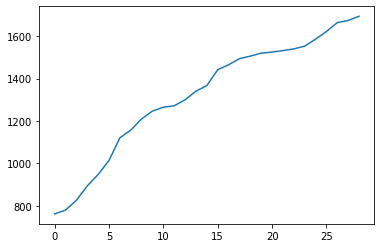

In [6]:
cases=data["total"] #odkomentirajte za da se koristat rudareni podatoci
cases=np.flip(cases,axis=0)
# cases_cum=cases.cumsum() #kom koga se koristat rudareni podatoci
# plt.plot(range(len(data['date'])),cases_cum)
plt.plot(range(len(data['date'])),cases)

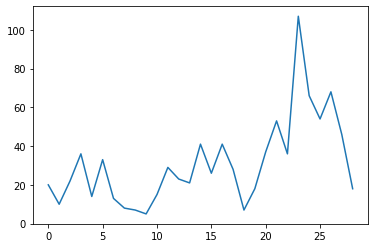

In [7]:
plt.plot(range(len(data['date'])),data['cases'])
#falat podatoci

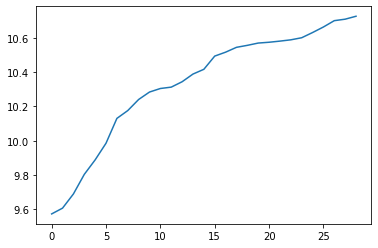

In [8]:
cases_cum_log=np.log2(cases)
plt.plot(range(len(data['date'])),cases_cum_log)

In [9]:
#Bidejki brojot na vkupni slucai ima najlinearna forma, regresioniot model ke go istreniram na nego
# cases=np.array(cases).reshape(-1,1)
lr=LinearRegression()
# lr=RidgeCV()
x_test=[0]
x=range(len(data['date']))
x_test.extend(range(x[-1],x[-1]+6)) #se testira za slednite 5 dena
x_test=np.array(x_test).reshape(-1,1)
x=np.array(x).reshape(-1,1)
lr.fit(x,cases)
print(lr.intercept_,lr.coef_)

871.3586206896553 [32.14679803]


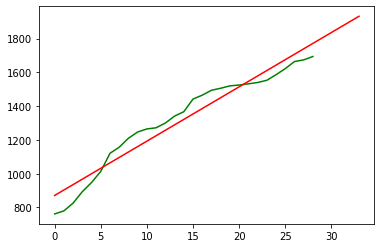

In [10]:
y_pred=lr.predict(x_test)
plt.plot(x,cases,c='g')
plt.plot(x_test,y_pred,c='r') #crvenata linija e predvidenoto

In [18]:
#Predviduvanjata za slednite 5 dena so ovoj model se:
y_pred_new_cases=np.array([y_pred[i+1]-y_pred[i] for i in range(1,len(y_pred)-1)])
y_pred_new_cases

array([32.14679803, 32.14679803, 32.14679803, 32.14679803, 32.14679803])

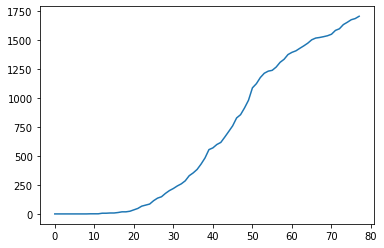

In [19]:
#ovde pocnuvam da rabotam so csv podatoci
data=pd.read_csv('corona_stats.csv')
cases=data['cases']
total=np.array(cases.cumsum())
# print(type(total))
plt.plot(total)

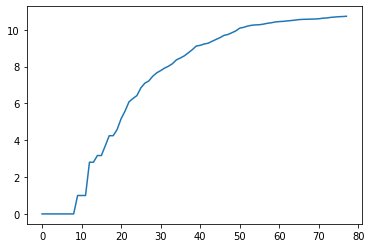

In [20]:
plt.plot(np.log2(total))

In [21]:
lr_csv=LinearRegression()
# lr_csv=LassoCV()
x_test_csv=[0]
x_csv=range(len(total))
x_test_csv.extend(range(x_csv[-1],x_csv[-1]+6)) #se testira za slednite 5 dena
x_test_csv=np.array(x_test_csv).reshape(-1,1)
x_csv=np.array(x_csv).reshape(-1,1)
lr_csv.fit(x_csv,total)
print(lr_csv.intercept_,lr_csv.coef_)

-364.1226874391433 [26.9172726]


[-364.12268744 1708.50730282 1735.42457542 1762.34184803 1789.25912063
 1816.17639323 1843.09366583]


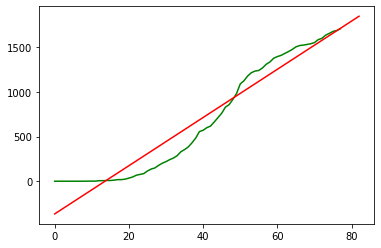

In [22]:
y_pred_csv=lr_csv.predict(x_test_csv)
plt.plot(x_csv,total,c='g')
print(y_pred_csv)
plt.plot(x_test_csv,y_pred_csv,c='r') #crvenata linija e predvidenoto

In [23]:
#Predviduvanjata za slednite 5 dena so ovoj model se:
y_pred_new_cases_csv=np.array([y_pred_csv[i+1]-y_pred_csv[i] for i in range(1,len(y_pred_csv)-1)])
y_pred_new_cases_csv

array([26.9172726, 26.9172726, 26.9172726, 26.9172726, 26.9172726])